In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
time_series_data = pd.read_csv("save.csv").to_numpy()[2,:]

In [3]:
data = pd.DataFrame(time_series_data, columns=["value"])

In [4]:
def create_lag_features(data, n_lags):
    df = data.copy()
    for i in range(1, n_lags + 1):
        df[f"lag_{i}"] = df["value"].shift(i)
    return df
def create_rolling_features(data, window):
    df = data.copy()
    df["rolling_mean"] = df["value"].rolling(window=window).mean()
    df["rolling_median"] = df["value"].rolling(window=window).median()
    df["rolling_std"] = df["value"].rolling(window=window).std()
    return df

window = 4  # Or any other appropriate number
n_lags = 60
# data_rolling = create_rolling_features(data, window)
# data_lagged = create_lag_features(data_rolling, n_lags)
data_lagged = create_lag_features(data, n_lags)

In [5]:
train_size = int(len(data_lagged) * (96/120))
train_data = data_lagged[:train_size].dropna()
test_data = data_lagged[train_size:]

X_train = train_data.drop("value", axis=1)
y_train = train_data["value"]
X_test = test_data.drop("value", axis=1)
y_test = test_data["value"]

In [6]:
# Without grid search

In [7]:
final_xgb_model = xgb.XGBRegressor(
    learning_rate=0.1,
    max_depth=4,
    subsample=0.6,
    colsample_bytree=0.6,
    n_estimators=500,
    objective="reg:gamma"
)

In [8]:
final_xgb_model.fit(X_train, y_train)
y_pred = final_xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 9122.39548885338


In [9]:
# With grid search

In [10]:
# xgb_model = xgb.XGBRegressor(objective="reg:gamma")
#
# param_grid = {
#     "learning_rate": [0.01, 0.1],
#     "max_depth": [3, 5, 7, 10],
#     "subsample": [0.5, 0.7, 1.0],
#     "colsample_bytree": [0.5, 0.7, 1.0],
#     "n_estimators": [100, 500, 1000],
# }
# tscv = TimeSeriesSplit(n_splits=5)
#
# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     scoring="neg_mean_squared_error",
#     cv=tscv,
#     verbose=1,
# )
#
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_
#
# final_xgb_model = xgb.XGBRegressor(**best_params,
#                                   objective="reg:gamma")    # squarederror, gamma, reg:linear, huber
# final_xgb_model.fit(X_train, y_train)
#
# y_pred = final_xgb_model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# print("Mean Squared Error:", mse)

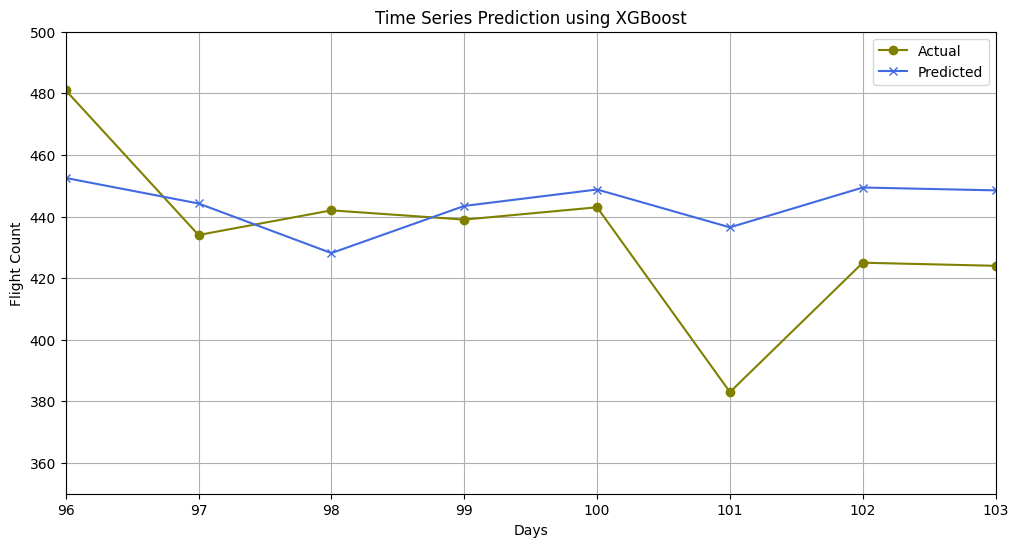

In [11]:
# Create a DataFrame to store actual and predicted values
results = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})

# Plot the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(results.index, results["Actual"], label="Actual", marker="o", color="olive")
plt.plot(results.index, results["Predicted"], label="Predicted", marker="x", color="royalblue")
plt.xlabel("Days")
plt.ylabel("Flight Count")
plt.xlim([96, 103])
plt.ylim([350, 500])
plt.title("Time Series Prediction using XGBoost")
plt.legend()
plt.grid(True)
plt.show()

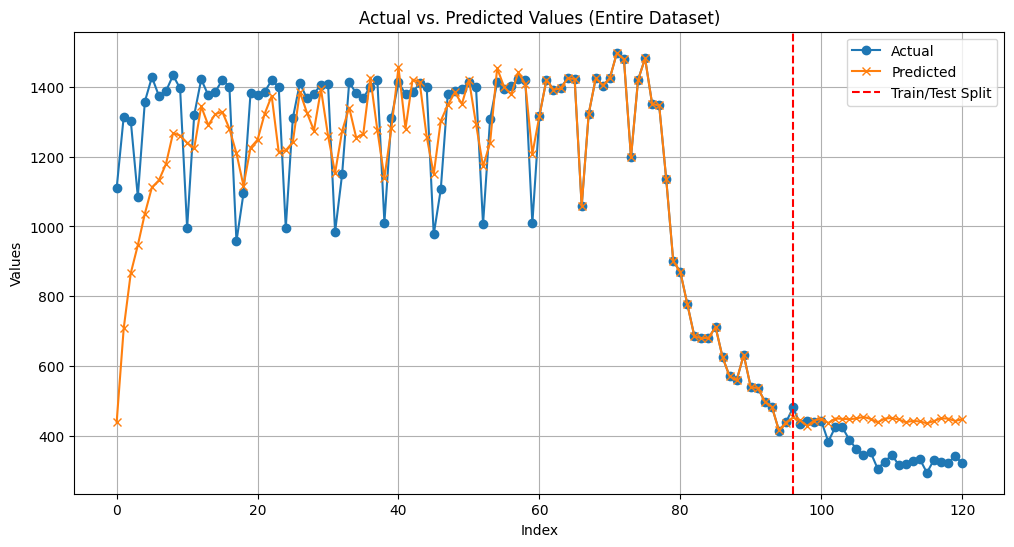

In [12]:
# Make predictions for the entire dataset
y_pred_all = final_xgb_model.predict(data_lagged.drop("value", axis=1))

# Create a DataFrame to store actual and predicted values for the entire dataset
results_all = pd.DataFrame({"Actual": data_lagged["value"], "Predicted": y_pred_all})

# Plot the actual and predicted values for the entire dataset
plt.figure(figsize=(12, 6))
plt.plot(results_all.index, results_all["Actual"], label="Actual", marker="o")
plt.plot(results_all.index, results_all["Predicted"], label="Predicted", marker="x")
plt.axvline(x=train_size, color="r", linestyle="--", label="Train/Test Split")
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Actual vs. Predicted Values (Entire Dataset)")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
range_start, range_end = 96, 102

y_actual_range = data.squeeze()[range_start:range_end]
y_pred_range = y_pred_all[range_start:range_end]

rmse = np.sqrt(mean_squared_error(y_actual_range, y_pred_range))
mae = mean_absolute_error(y_actual_range, y_pred_range)

print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

Root Mean Squared Error (RMSE): 25.888885831218573
Mean Absolute Error (MAE): 19.378306070963543
